<a href="https://colab.research.google.com/github/Wildemberg-Projects/Plants-Diseases/blob/will/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalando dependências e Definição de Variáveis Importantes

In [ ]:
# Instalação de Dependências
# Para utilização do Colab, modifique o '%' por '!'
# As abaixo comentadas são somente para instalar em ambiente local
# %pip install -q -U tensorflow
# %pip install -q -U keras
# %pip install -q -U numpy
# %pip install -q -U pandas
# %pip install -q -U Jinja2
# Uso da GPU precisa ser habilitado pelo comando a seguir
# %pip install tensorflow[and-cuda]
%pip install -q -U tensorflow-addons
%pip install -q -U tensorflow-datasets
%pip install -q -U keras-utils
%pip install -q -U matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 33.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_datasets as tfds
import pandas as pd
from numpy import mean
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, PrecisionAtRecall, SensitivityAtSpecificity, SpecificityAtSensitivity, Recall
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [ ]:
METRICS = [BinaryAccuracy(name = 'accuracy'),
           TruePositives(thresholds = 0.5, name = 'tp'),
           TrueNegatives(thresholds = 0.5, name = 'tn'),
           FalsePositives(thresholds = 0.5, name = 'fp'),
           FalseNegatives(thresholds = 0.5, name = 'fn'),
           PrecisionAtRecall(recall = 0.5, name = 'precision'),
           SensitivityAtSpecificity(0.5, name = 'sensitivity'),
           SpecificityAtSensitivity(sensitivity = 0.5, name = 'specificity'),
           Recall(name='recall')]

### Carregando dados para utilização

In [ ]:
# Coletando dados
tf.keras.backend.clear_session() # Limpar o CACHE da seção
(ds_train), info = tfds.load('plant_village', split='train', with_info=True)

# a estrutura de uma imagem (256,256,3), representa a largura e altura em pixels,
# e o 3 representa a quantidade de canais de cores pq é RGB

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteECNCBM/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
# Carregamento e pré-processamento das imagens locais.
ds = tf.keras.preprocessing.image_dataset_from_directory("/root/tensorflow_datasets/downloads/extracted/ZIP.data.mend.com_publ-file_data_tywb_file_d565-c1rDQyRTmE0CqGGXmH53WlQp0NWefMfDW89aj1A0m5D_A/Plant_leave_diseases_dataset_without_augmentation",
                                                         shuffle=True,
                                                         image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                         batch_size=BATCH_SIZE)
print(ds)

Found 55448 files belonging to 39 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Observando os dados

In [ ]:
# Verificação do nome das classes do dataset
class_name = ds.class_names
print(class_name)
print("Possui {} lotes de 32 imagens cada.".format(len(ds)))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl

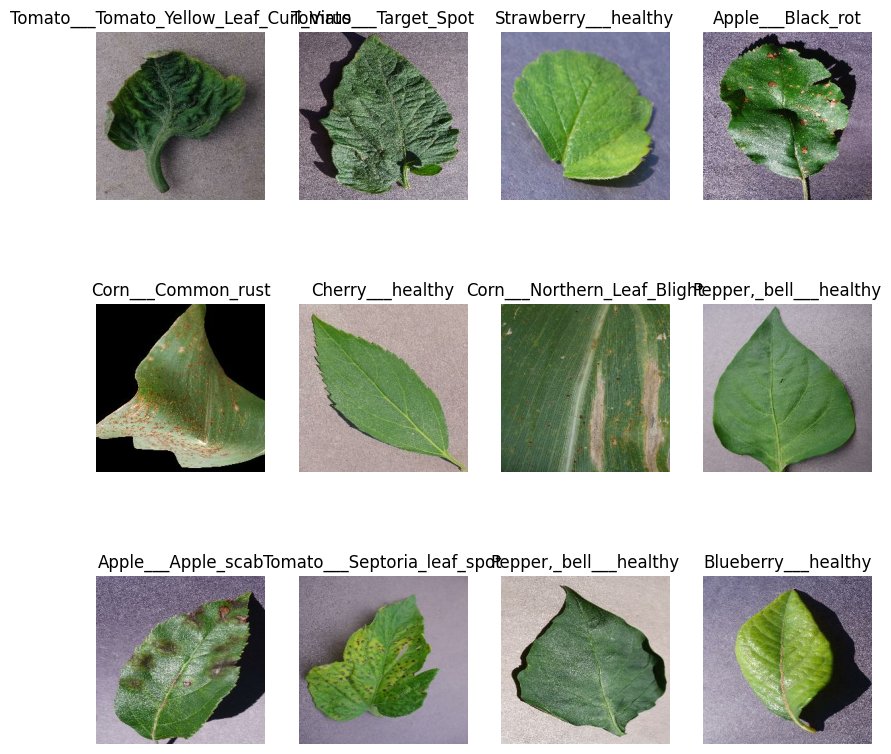

In [ ]:
plt.figure(figsize=(10,10))
for image, label in ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    # print(image[i].numpy())
    # print(image[i].shape)
    # print(label[i].numpy())
    plt.title(class_name[label[i]])
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
# Quantidade de lotes de 32 imagens (BATCHS)
len(ds)

1733

### Criando repartição de treino, validação e teste

In [ ]:
# 80% ==> training
# 20% ==> 10% validation, 10% test
train_size = 0.8
train_size = int(len(ds)*train_size)
print(train_size)

1386


In [ ]:
# Randomização dos dados
ds = ds.shuffle(buffer_size=1000, seed=12)

In [ ]:
# Atribuição e verificação da quantidade de dados de treino do dataset
train_ds = ds.take(train_size)
len(train_ds)

1386

In [ ]:
# Separação dos 10% de validação e 10% de teste
test_ds = ds.skip(int(train_size))
test_size = int(len(test_ds)*0.5)
validation_ds = test_ds.take(test_size)
test_ds = test_ds.skip(test_size)
len(validation_ds)
len(test_ds)

174

### Fazendo processamento dos dados

In [ ]:
# Criando um cache das imagens (Deixa a imagem pré-pronta para uso)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Pré-processamento com ajuste dos dados e ajuste de tamanho
# Será aplicado dentro da estrutura do modelo para garantir que sempre seja feito em todas as imagens
resize_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) # torna o valor do RGB para um intervalo [0,1]
])

In [ ]:
# Faz novas imagens para nossa base de dados com rotação e inversão para diversidade dos mesmos dados
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Aplicando a função de geração das variações das imagens
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)